In [ ]:
!gdown "1xMDTrHIK_gw3vLsmLZc8N2vCXNGouWQS&confirm=t"
!unzip seminar_objdet_retina_oi5_ball.zip -d seminar_objdet_retina_oi5_ball

In [ ]:
!git clone -b autumn_2023 https://github.com/AlekseySpasenov/dl-course.git

Cloning into 'dl-course'...
remote: Enumerating objects: 502, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 502 (delta 36), reused 56 (delta 15), pack-reused 394
Receiving objects: 100% (502/502), 208.91 MiB | 31.96 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Updating files: 100% (118/118), done.


In [ ]:
import os
import sys
import cv2
import json
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torchvision.transforms.functional import to_tensor, normalize

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)


Device is: cpu


In [ ]:
# rename dir
from dl_course.lecture6.visualization import show_image, draw_predictions

In [ ]:
def make_tensor(image, device=None):
    tensor = to_tensor(image).unsqueeze(0)
    tensor = normalize(tensor,
                       mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
    if device:
        tensor = tensor.to(device)
    return tensor

In [ ]:
def run_and_show(model, image_or_tensor, threshold, class_to_label_map, verbose=False):
    if isinstance(image_or_tensor, np.ndarray):
        tensor = make_tensor(image_or_tensor)
        image = image_or_tensor
    elif isinstance(image_or_tensor, torch.Tensor):
        image = (image_or_tensor.numpy()[0] * 0.25) + 0.5
        tensor = image_or_tensor.permute(0, 3, 1, 2)
    else:
        raise NotImplementedError(type(image_or_tensor))

    with torch.no_grad():
        nms_scores, nms_classes, bboxes = model(tensor)

    nms_scores = nms_scores.cpu()
    nms_classes = nms_classes.cpu()
    bboxes = bboxes.cpu()

    if verbose:
        print(nms_scores.size(), nms_scores[:8])
        print(nms_classes.size(), nms_classes[:8])
        print(bboxes.size(), bboxes[:8])

    image_with_predictions = draw_predictions(image, bboxes, nms_scores, nms_classes, class_to_label_map, threshold=threshold)
    show_image(image_with_predictions)

In [ ]:
with open("./seminar_objdet_retina_oi5_ball/coco_id_to_name.json", "rt") as fp:
    coco_class_to_label_map = json.load(fp)
coco_class_to_label_map = {int(k) - 1: v for k, v in coco_class_to_label_map.items()}

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [ ]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)
model.to(device)

In [ ]:
%reload_ext autoreload

import tqdm

from torchvision import transforms
from torch.utils.data import DataLoader

from dl_course.lecture6.dataset import DetectionDataset
from dl_course.lecture6.retinanet.dataloader import Normalizer, Resizer, Augmenter, collater, AspectRatioBasedSampler, UnNormalizer

In [ ]:
train_transforms = transforms.Compose([
    Normalizer(), Augmenter(), Resizer()
])

val_transforms = transforms.Compose([
    Normalizer(), Resizer()
])

In [ ]:
train_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                 transforms=train_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
train_sampler = AspectRatioBasedSampler(train_dataset, batch_size=4, drop_last=False) # deepdive
train_dataloader = DataLoader(train_dataset, num_workers=8, collate_fn=collater, batch_sampler=train_sampler)

val_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                               transforms=val_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
val_sampler = AspectRatioBasedSampler(val_dataset, batch_size=4, drop_last=False)
val_dataloader = DataLoader(val_dataset, num_workers=8, collate_fn=collater, batch_sampler=val_sampler)

In [ ]:
%%shell
rm -rf vision
rm utils.py transforms.py coco_eval.py engine.py coco_utils.py
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout release/2.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 415301, done.
remote: Counting objects: 100% (24464/24464), done.
remote: Compressing objects: 100% (1926/1926), done.
remote: Total 415301 (delta 23608), reused 22888 (delta 22526), pack-reused 390837
Receiving objects: 100% (415301/415301), 797.86 MiB | 36.19 MiB/s, done.
Resolving deltas: 100% (385830/385830), done.
Branch 'release/2.0' set up to track remote branch 'release/2.0' from 'origin'.
Switched to a new branch 'release/2.0'


In [ ]:
#from torch._six import inf
from torch import inf

In [ ]:
from engine import train_one_epoch, evaluate

In [ ]:
import numpy as np
import gc

In [ ]:
def routine(model, scheduler, train_loader, val_loader):
    model.train()
    epoch_loss = []
    torch.cuda.empty_cache()
    for iter_num, data in tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        optimizer.zero_grad()

        loss = model(data['img'].to(device).float(), data['annot'].to(device))

        if bool(loss == 0):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        epoch_loss.append(float(loss.item()))
        del data

    gc.collect()
    torch.cuda.empty_cache()

    print('Epoch: {} | Iteration: {} | Epoch loss: {:1.5f}'\
          .format(epoch_num, iter_num, np.mean(epoch_loss)))
    scheduler.step(np.mean(epoch_loss)) # should be val loss

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [ ]:
epochs = 5
for epoch_num in range(epochs):
    routine(model, scheduler, train_dataloader, val_dataloader)

  0%|          | 0/719 [00:06<?, ?it/s]


IndexError: ignored

Я не знаю как адаптировать код с семинара, чтоб торчовая модель принимала дата лоудер для ретины

Я больше не могу, я прочитал много кода, я всё равно не могу это сделать 🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑🚑

In [2]:
!wget https://data.deepai.org/PascalVOC2012.zip
!unzip PascalVOC2012.zip
!mv voc2012 VOCdevkit
!python -m pip install pytorch-lightning

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from PIL import Image


USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"

# Параметры тренировки и визуализации.
TRAIN = True  # Если False, будут использоваться заранее посчитанные графики
              # вместо реальной тренировки (полезно для демонстрации на ноутбуках без GPU).

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
MULTICLASS = True
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 21


In [5]:
from torchvision.datasets import VOCDetection
from torchvision import transforms

In [6]:
trainset_raw = VOCDetection(DATA_ROOT, VOC_YEAR, "train", download=False)

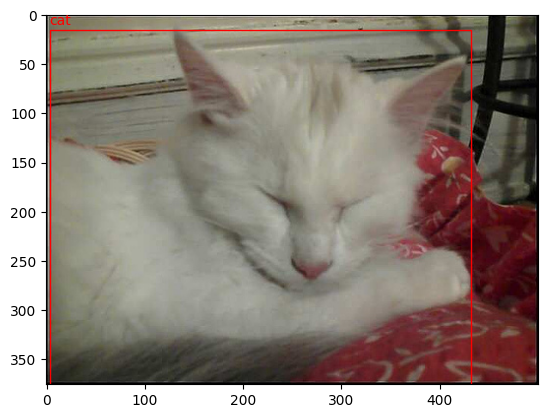

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

sample_index = random.randint(0, len(trainset_raw) - 1)
image, target = trainset_raw[sample_index]

plt.imshow(image)
ax = plt.gca()

for obj in target['annotation']['object']:
    bbox = obj['bndbox']
    xmin, ymin, xmax, ymax = float(bbox['xmin']), float(bbox['ymin']), float(bbox['xmax']), float(bbox['ymax'])
    width = xmax - xmin
    height = ymax - ymin

    class_label = obj['name']

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin - 5, class_label, color='r')

plt.show()


In [13]:
class Scaler(object):
    def __init__(self, size):
        self._size = size
        self._padding = 0

    def set_padding(self, padding):
        self._padding = padding

    def __call__(self, image, boxes):
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]

        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape

        # Масштабирование изображения
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2

        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]

        if grayscale:
            result = result[:, :, 0]

        boxes[:, [0, 2]] = (boxes[:, [0, 2]] * scale) + offset_x
        boxes[:, [1, 3]] = (boxes[:, [1, 3]] * scale) + offset_y

        return result, boxes


def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask


In [9]:
import albumentations as A
class SSDAugmentation:
    def __init__(self):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Blur(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.RandomBrightnessContrast(p=0.2),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    def __call__(self, image, boxes, labels):
        augmented = self.transform(image=image, bboxes=boxes, labels=labels)
        return augmented

In [207]:
import torch
from torchvision.transforms import functional as F

class SSD300VGG16Dataset(torch.utils.data.Dataset):
    def __init__(self, root, year, image_size,
                 download=False,
                 train=False, train_fraction=0.8,
                 padding=0,
                 augmentations=None):
        self._dataset = VOCDetection(root, year, "trainval", download=download)
        self._image_size = np.array(image_size)
        self._padding = padding

        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._augmenter = augmentations
        self._transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)
            )
        ])
    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)


    def __getitem__(self, idx):
        image, target = self._dataset[self._indices[idx]]

        # Проходим по всем объектам в аннотации и создаем список баундинг боксов
        boxes = []
        labels = []

        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            xmin, ymin, xmax, ymax = float(bbox['xmin']), float(bbox['ymin']), float(bbox['xmax']), float(bbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])

            # Получаем метку класса
            class_label = obj['name']

            # Преобразуем строковую метку в числовой формат (по желанию)
            labels.append(LABELS.index(class_label))

        # Применяем аугментации, если они заданы
        if self._augmenter:
            augmented = self._augmenter(image=np.array(image), boxes=boxes, labels=labels)
            image = augmented['image']
            boxes = np.array(augmented['bboxes'], dtype=np.float32)
            labels = np.array(augmented['labels'], dtype=np.int64)

        boxes = torch.tensor(boxes, dtype=torch.float32).clone().detach()
        labels = torch.tensor(labels, dtype=torch.int64).clone().detach()

        image, boxes = self._image_scaler(image, boxes)

        image = self._transform(image)
        boxes = torch.tensor(boxes, dtype=torch.float32).clone().detach()
        labels = torch.tensor(labels, dtype=torch.int64).clone().detach()

        annotation = torch.cat((boxes, labels.unsqueeze(1)), dim=1)

        return {'image': image, 'annotation': annotation}



In [202]:
train_ssd = SSD300VGG16Dataset(
    DATA_ROOT,
    VOC_YEAR,
    train=True,
    image_size=(300, 300),
    augmentations=SSDAugmentation()
)

<ipython-input-201-0d54e806e4b2>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes, dtype=torch.float32).clone().detach()
<ipython-input-201-0d54e806e4b2>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int64).clone().detach()


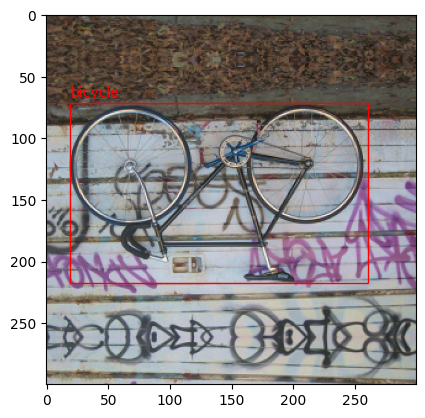

In [206]:
sample_index = random.randint(0, len(train_ssd) - 1)
sample = train_ssd[sample_index]
image, target = sample['image'], sample['annotation']

plt.imshow(image.permute(1, 2, 0))
ax = plt.gca()

for ann in target:
    xmin, ymin, xmax, ymax = ann[:4].tolist()
    width = xmax - xmin
    height = ymax - ymin

    class_label = LABELS[ann[4].int()]

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin - 5, class_label, color='r')

plt.show()


<ipython-input-201-0d54e806e4b2>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes, dtype=torch.float32).clone().detach()
<ipython-input-201-0d54e806e4b2>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int64).clone().detach()


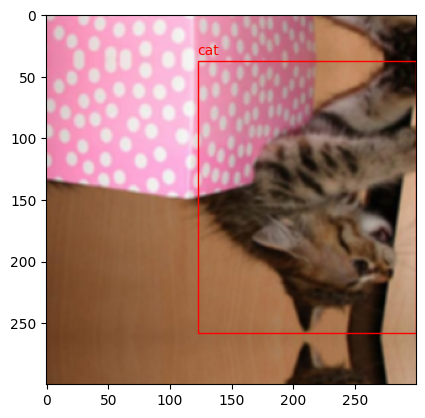

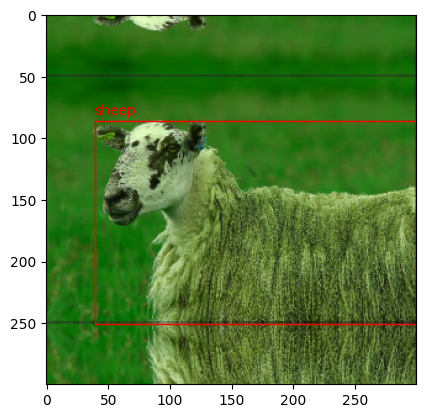

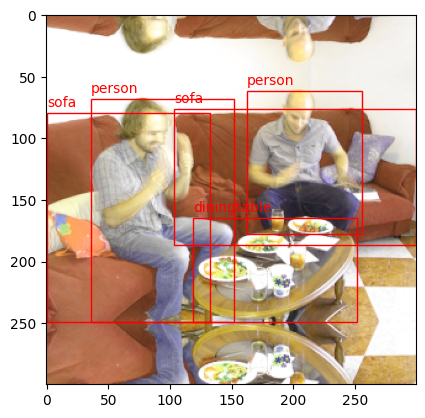

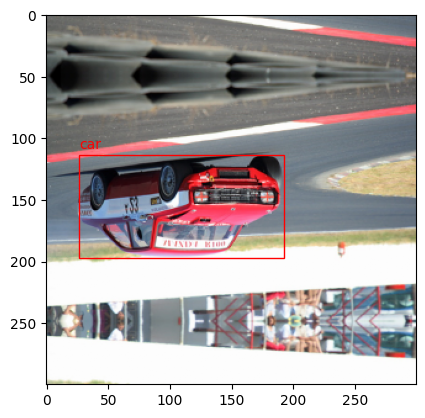

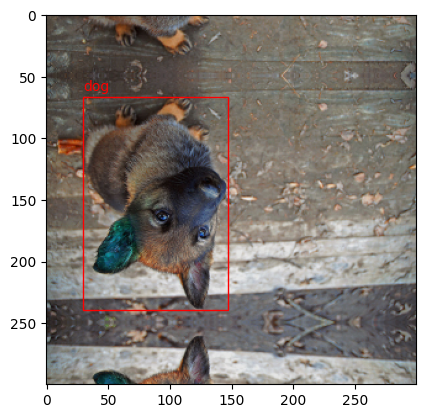

In [208]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def show_images_with_boxes(dataset, num_images=5):
    for _ in range(num_images):
        idx = random.randint(0, len(dataset) - 1)

        sample = dataset[idx]
        image, target = sample['image'], sample['annotation']

        fig, ax = plt.subplots(1)
        ax.imshow(image.permute(1, 2, 0))

        for ann in target:
            xmin, ymin, xmax, ymax = ann[:4].tolist()
            width = xmax - xmin
            height = ymax - ymin
            class_label = LABELS[ann[4].int()]

            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            ax.text(xmin, ymin - 5, class_label, color='r')

        plt.show()


show_images_with_boxes(train_ssd)


In [209]:
import torch
from torchvision.models.detection import ssd300_vgg16

In [217]:
train_dataset[110]['image'].shape, train_dataset[110]['annotation'].shape

<ipython-input-176-e4e7070398af>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes.clone().detach(), dtype=torch.float32)
<ipython-input-176-e4e7070398af>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.int64)


(torch.Size([3, 300, 300]), torch.Size([3, 5]))

In [279]:
import torch
import torch.nn.functional as F

class TotalLoss(torch.nn.Module):
    def __init__(self, gamma=2, weight=None, alpha=0.5):
        super(TotalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.alpha = alpha

    def forward(self, predictions, target):
        cnt_bb_elements = [len(t) for t in target]
        target = torch.cat(target, dim=0)
        true_boxes, true_labels = target[:, :4], target[:, 4].long()

        pred_boxes = [pred["boxes"] for pred in predictions]
        pred_labels = [pred["labels"] for pred in predictions]
        pred_scores = [pred["scores"] for pred in predictions]

        for i in range(len(cnt_bb_elements)):
            topk_indices = torch.topk(pred_scores[i], cnt_bb_elements[i], dim=0, largest=True, sorted=True)[1]
            pred_boxes[i] = pred_boxes[i][topk_indices]
            pred_labels[i] = pred_labels[i][topk_indices]
            pred_scores[i] = pred_scores[i][topk_indices]

        pred_boxes = torch.cat(pred_boxes, dim=0)
        pred_labels = torch.cat(pred_labels, dim=0)
        pred_scores = torch.cat(pred_scores, dim=0)

        bbox_loss = F.smooth_l1_loss(pred_boxes, true_boxes)

        # Объединяем вероятности и метки классов
        combined_scores_labels = torch.cat([F.log_softmax(pred_scores, dim=1), F.one_hot(pred_labels, num_classes=len(pred_scores[0]))], dim=1)

        # Используем F.cross_entropy с объединенными данными
        class_loss = F.cross_entropy(combined_scores_labels, true_labels)

        total_loss = bbox_loss + class_loss

        return total_loss


In [177]:
train_dataset = SSD300VGG16Dataset(
    root=DATA_ROOT,
    year=VOC_YEAR,
    image_size=(300, 300),
    train=True,
    augmentations=SSDAugmentation()
)

In [178]:
valid_dataset = SSD300VGG16Dataset(
    root=DATA_ROOT,
    year=VOC_YEAR,
    image_size=(300, 300),
    train=False,
)

In [220]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

In [221]:
model = ssd300_vgg16(weights=None, num_classes=NUM_CLASSES)

In [277]:
print(model)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
def collate_fn(batch):
    return batch

In [245]:
import random
import numpy as np
import torch
import torchvision
import pytorch_lightning as pl
from torchvision.datasets import CIFAR10



class Module(pl.LightningModule):
    def __init__(
          self,
          model,
          loss_fn,
          optimizer_fn,
          trainset,
          testset,
          collate_fn,
          lr_scheduler_fn=None,
          batch_size=16
    ):
        super().__init__()
        self._model = model
        self._optimizer_fn = optimizer_fn
        self._lr_scheduler_fn = lr_scheduler_fn
        self._criterion = loss_fn()
        self._batch_size = batch_size
        self._trainset = trainset
        self._testset = testset
        self._collate_fn = collate_fn

    def forward(self, input):
        return self._model(input)

    # def calculate_iou(self, predicted, target):
    #     predicted = predicted.to(torch.long)
    #     target = target.to(torch.long)

    #     intersection = (predicted & target).sum().item()
    #     union = (predicted | target).sum().item()
    #     iou = intersection / union
    #     return iou

    def training_step(self, batch, batch_idx):
        # {'image': image, 'annotation': annotation}
        x = [sample['image'] for sample in batch]
        ann = [sample['annotation'] for sample in batch]
        predictions = self._model(x)
        loss = self._criterion(predictions, ann)

        # predicted_masks = (logits > 0.5).float()
        # iou = self.calculate_iou(predicted_masks, y)

        self.logger.experiment.add_scalars("loss",
                                           {"train": loss},
                                           global_step=self.global_step)
        # self.logger.experiment.add_scalars("iou",
        #                                    {"train": iou},
        #                                    global_step=self.global_step)
        return loss


    def validation_step(self, batch, batch_idx):
        x = [sample['image'] for sample in batch]
        ann = [sample['annotation'] for sample in batch]
        predictions = self._model(x)
        loss = self._criterion(predictions, ann)

        # predicted_masks = (logits > 0.5).float()
        # iou = self.calculate_iou(predicted_masks, y)

        self.logger.experiment.add_scalars("loss",
                                           {"val": loss},
                                           global_step=self.global_step)
        # self.logger.experiment.add_scalars("iou",
        #                                    {"val": iou},
        #                                    global_step=self.global_step)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self._trainset,
            batch_size=self._batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=2,
            collate_fn=self._collate_fn
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self._testset,
            batch_size=self._batch_size,
            shuffle=False,
            num_workers=2,
            collate_fn=self._collate_fn
        )

    def configure_optimizers(self):
        optimizer = self._optimizer_fn(self._model)
        scheduler = self._lr_scheduler_fn(optimizer)
        if scheduler:
            return [optimizer], [scheduler]
        else:
            return optimizer


def train_model(
    model,
    loss_fn,
    optimizer_fn,
    trainset,
    testset,
    collate_fn,
    lr_scheduler_fn=None,
    batch_size=4,
    eval_steps=250,
    num_epochs=1,
):
    model = Module(
        model=model,
        loss_fn=loss_fn,
        optimizer_fn=optimizer_fn,
        trainset=trainset,
        testset=testset,
        lr_scheduler_fn=lr_scheduler_fn,
        collate_fn=collate_fn,
        batch_size=batch_size,
    )

    trainer = pl.Trainer(
        accelerator='auto',
        max_epochs=num_epochs,
        val_check_interval=eval_steps
    )

    trainer.fit(model)


In [280]:
train_model(
    model,
    TotalLoss,
    make_optimizer,
    train_dataset,
    valid_dataset,
    lr_scheduler_fn=lambda opt: None,
    eval_steps=500,
    batch_size=10,
    num_epochs=1,
    collate_fn=collate_fn,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | _model     | SSD       | 26.3 M
1 | _criterion | TotalLoss | 0     
-----------------------------------------
26.2 M    Trainable params
38.7 K    Non-trainable params
26.3 M    Total params
105.142   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-176-e4e7070398af>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes.clone().detach(), dtype=torch.float32)
<ipython-input-176-e4e7070398af>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.int64)
<ipython-input-176-e4e7070398af>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes.clone().detach(), dtype=torch.float32)
<ipython-input-176-e4e7070398af>:73: UserWarning: To copy construct from a tensor, it is recommen

IndexError: ignored